<a href="https://colab.research.google.com/github/robson-rsp/datascience/blob/main/regression/uk_used_cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Contexto

## Definição de preços de automóveis usados.

O conjunto de dados utilizado neste kernel contém informações e preços de milhares de automóveis usados. Os carros estão localizados na Inglaterra portanto informações como preços kilometragem entre outras estão no padrão inglês. 

Os atributos do conjunto são:

*    model: Modelo do carro não importando a marca.
*    year: Ano de fabricação.
*    price: Preço em Euros.
*    transmission: Tipo de transmissão.
*    mileage: Distância percorrida por unidade de combustível.
*    fuelType: Tipo de combustível.
*    tax: Equivalente brasileiro à Taxa de Licenciamento Veicular.
*    mpg: Milhas por galão. É o equivalente brasileiro a kilômetros por litro. Também pode ser visto como autonomia.
*    enginesize: Tamanho do motor.




Fonte: https://www.kaggle.com/datasets/adityadesai13/used-car-dataset-ford-and-mercedes

#Imports iniciais

In [ ]:
%pip install ipython-autotime --upgrade
%pip install matplotlib       --upgrade
%pip install scikit-learn     --upgrade
%pip install seaborn          --upgrade

In [ ]:
from google.colab import drive, files
from os           import listdir
from os.path      import isfile, join

import pandas as pd

drive.mount('/content/drive')

%load_ext autotime

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 515 µs (started: 2023-03-11 00:17:54 +00:00)


In [ ]:
data_path = '/content/drive/MyDrive/datasets/uk-used-cars'
files = [f for f in listdir(data_path) if isfile(join(data_path, f))]

files.remove('unclean cclass.csv')
files.remove('unclean focus.csv')

brands = list()
for f in files:
    df = pd.read_csv((data_path + '/' + f), encoding='utf-8')
    brands.append(df)

print(files)

['bmw.csv', 'vw.csv', 'hyundi.csv', 'cclass.csv', 'skoda.csv', 'ford.csv', 'audi.csv', 'vauxhall.csv', 'merc.csv', 'toyota.csv', 'focus.csv']
time: 3.39 s (started: 2023-03-11 00:17:55 +00:00)


Ignorei os datasets que começam com 'unclean'. Além disso, as marcas dos carros podem ser descobertas olhando os nomes dos arquivos. Vou aproveitar que estou montando o dataset e criar uma coluna com as marcas. É possível que esse novo atributo ajude no desempenho dos modelos. Mas, há algumas inconsistências aqui. Por exemplo, o arquivo 'focus.csv' se refere a um carro da Ford. Outro exemplo, o arquivo 'cclass.csv' se refere ao modelo C-Class da Mercedes.

Para resolver esse problema vou criar uma nova lista baseada em 'files'. Essa lista vai ter a mesma ordem dos itens de 'files', mas sem os '.csv' e com alguns nomes, como os exemplificados, substituídos pelas marcas corretas.


In [ ]:
brand_names = ['bmw', 'vw', 'hyundi', 'mercedes', 'skoda', 'ford', 'audi', 'vauxhall', 'mercedes', 'toyota', 'ford']

time: 932 µs (started: 2023-03-11 00:19:23 +00:00)


##Ajustes iniciais nos atributos.

Ajustes essenciais para começar. Ainda não estamos na fase de engenharia de atributos, por isso, as alterações feitas aqui servirão para montar um único dataset com os arquivos listados. Também facilitarão o entendimento das visualizações.

In [ ]:
for index, dataset in enumerate(brands):
  columns_original = list(dataset.columns)
  columns_lower = list(map(lambda x: x.lower(), columns_original))
  columns_new = {key: value for (key, value) in zip(columns_original, columns_lower)}
  brands[index].rename(columns=columns_new, inplace=True)
  brands[index].rename(columns={'tax(£)':'tax'}, inplace=True)
  print(list(brands[index].columns))

['model', 'year', 'price', 'transmission', 'mileage', 'fueltype', 'tax', 'mpg', 'enginesize']
['model', 'year', 'price', 'transmission', 'mileage', 'fueltype', 'tax', 'mpg', 'enginesize']
['model', 'year', 'price', 'transmission', 'mileage', 'fueltype', 'tax', 'mpg', 'enginesize']
['model', 'year', 'price', 'transmission', 'mileage', 'fueltype', 'enginesize']
['model', 'year', 'price', 'transmission', 'mileage', 'fueltype', 'tax', 'mpg', 'enginesize']
['model', 'year', 'price', 'transmission', 'mileage', 'fueltype', 'tax', 'mpg', 'enginesize']
['model', 'year', 'price', 'transmission', 'mileage', 'fueltype', 'tax', 'mpg', 'enginesize']
['model', 'year', 'price', 'transmission', 'mileage', 'fueltype', 'tax', 'mpg', 'enginesize']
['model', 'year', 'price', 'transmission', 'mileage', 'fueltype', 'tax', 'mpg', 'enginesize']
['model', 'year', 'price', 'transmission', 'mileage', 'fueltype', 'tax', 'mpg', 'enginesize']
['model', 'year', 'price', 'transmission', 'mileage', 'fueltype', 'engines

Vou adicionar as colunas 'tax' e 'mpg' aos datasets que não têm.

In [ ]:
brands[3]['tax']  = None
brands[3]['mpg']  = None
brands[-1]['tax'] = None
brands[-1]['mpg'] = None

time: 7.99 ms (started: 2023-03-11 00:19:57 +00:00)


Agora, é preciso reordenar as colunas dos dataframes acima para que elas fiquem dispostas da mesma forma dos demais. Isso será necessário quando eu for concatená-los um embaixo do outro para formar um grande dataset.

In [ ]:
columns    = ['model', 'year', 'price', 'transmission', 'mileage', 'fueltype', 'tax', 'mpg', 'enginesize']
brands[3]  = brands[3][columns]
brands[-1] = brands[-1][columns]

time: 10.8 ms (started: 2023-03-11 00:20:09 +00:00)


Agora que as colunas estão formatadas da mesma maneira, posso concatenar os dataframes.

In [ ]:
dataset = pd.DataFrame()

for bn, data in zip(brand_names, brands):
  data = data.copy()
  data['brand'] = bn
  dataset = pd.concat([dataset, data], axis=0)
    
dataset = dataset.reset_index().drop('index', axis=1)

time: 99.7 ms (started: 2023-03-11 00:20:18 +00:00)


#EDA

In [ ]:
dataset.head(5)

,model,year,price,transmission,mileage,fueltype,tax,mpg,enginesize,brand
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0,bmw
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0,bmw
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0,bmw
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5,bmw
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0,bmw


time: 26.2 ms (started: 2023-03-11 00:22:05 +00:00)


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108540 entries, 0 to 108539
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   model         108540 non-null  object 
 1   year          108540 non-null  int64  
 2   price         108540 non-null  int64  
 3   transmission  108540 non-null  object 
 4   mileage       108540 non-null  int64  
 5   fueltype      108540 non-null  object 
 6   tax           99187 non-null   object 
 7   mpg           99187 non-null   object 
 8   enginesize    108540 non-null  float64
 9   brand         108540 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 8.3+ MB
time: 62.9 ms (started: 2023-03-11 00:22:05 +00:00)


Vou mudar os tipos de dados das colunas 'tax' e 'mpg' para float64. Elas estão definidas como 'object' por causa dos valores None que eu atribui a elas. O Pandas, por padrão, sobrescreveu o tipo para 'object'.

In [ ]:
dataset['tax'] = dataset['tax'].astype('float64')
dataset['mpg'] = dataset['mpg'].astype('float64')

time: 63 ms (started: 2023-03-11 00:22:11 +00:00)


In [ ]:
dataset[['year', 'price', 'mileage', 'tax', 'mpg']].describe()

,year,price,mileage,tax,mpg
count,108540.000000,108540.000000,108540.000000,99187.000000,99187.000000
mean,2017.098028,16890.124046,23025.928469,120.299838,55.166825
std,2.130057,9756.266820,21176.423684,63.150926,16.138522
min,1970.000000,450.000000,1.000000,0.000000,0.300000
25%,2016.000000,10229.500000,7491.750000,125.000000,47.100000
50%,2017.000000,14698.000000,17265.000000,145.000000,54.300000
75%,2019.000000,20940.000000,32236.000000,145.000000,62.800000
max,2060.000000,159999.000000,323000.000000,580.000000,470.800000


time: 49 ms (started: 2023-03-11 00:22:16 +00:00)


A tabela acima apresenta fortes indícios de presença de outliers nos atibutos considerados. O ano do automóvel, por exemplo, possui como valor máximo 2060 e mínimo 1970. Mesmo sendo possível existir carros fabricados em 1970, a média é 2017, o desvio padrão é 2 e 25% dos automóveis foram fabricados antes de 2016. Portando, 1970 tem grandes chances se ser um outlier. Em 'price' também podemos ver isso com valores mínimos muito distantes da média somada com o desvio padrão e levando em conta os quartis. O mesmo acontece com 'mileage'.

##Data visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

time: 838 ms (started: 2023-03-11 00:23:03 +00:00)


###Categorical features

Vou fazer gráficos comparando a média de preços dos automoveis com cada classe encontrada em cada atributo exceto 'model'. São muitos modelos para se fazer um gráfico legível. Acho que será muito mais relevante levar em conta a marca do carro.

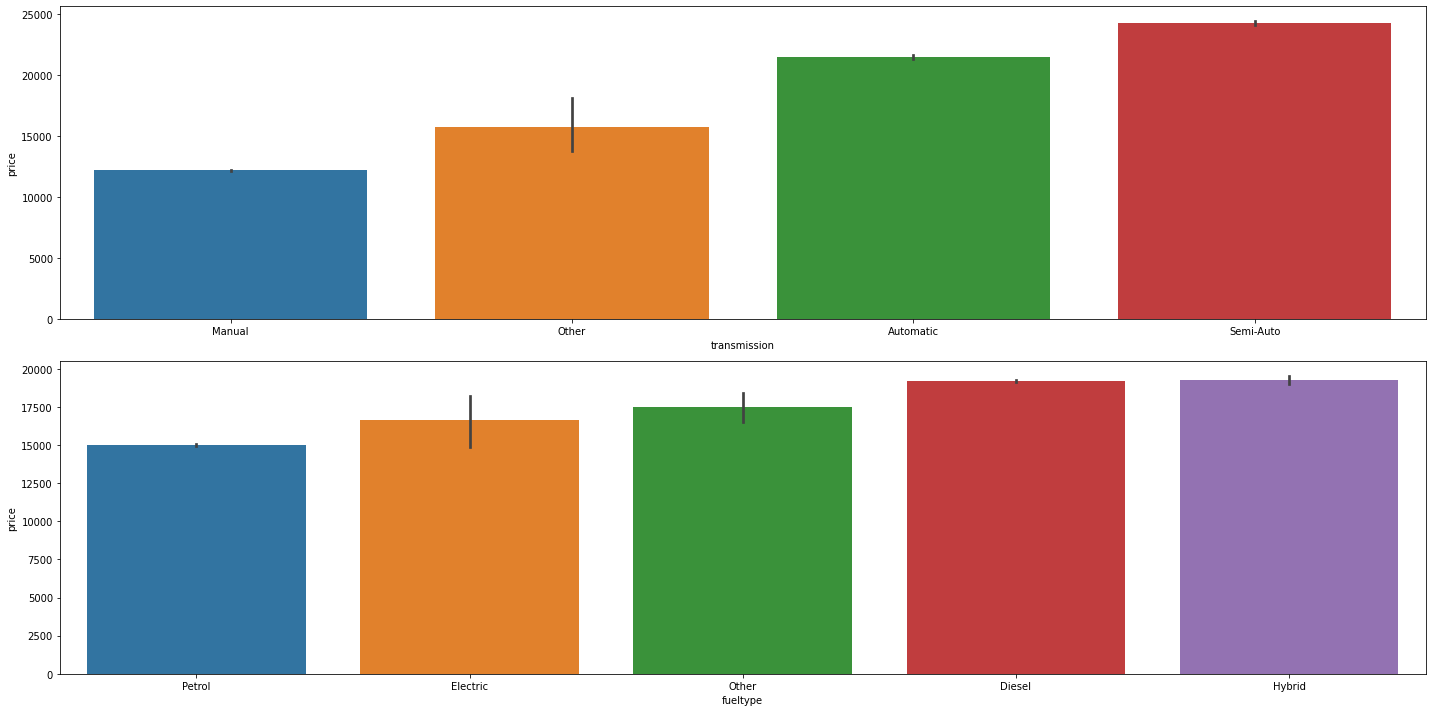

time: 3.09 s (started: 2023-03-11 00:23:29 +00:00)


In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(20,10))
axs = axs.ravel()

mean_price_transmission = dataset.groupby(['transmission']).mean().sort_values(by='price').index
mean_price_fueltype = dataset.groupby(['fueltype']).mean().sort_values(by='price').index

sns.barplot(data=dataset, x='transmission', y='price', order=mean_price_transmission, ax=axs[0])
sns.barplot(data=dataset, x='fueltype', y='price', order=mean_price_fueltype, ax=axs[1])

plt.tight_layout()
plt.show()

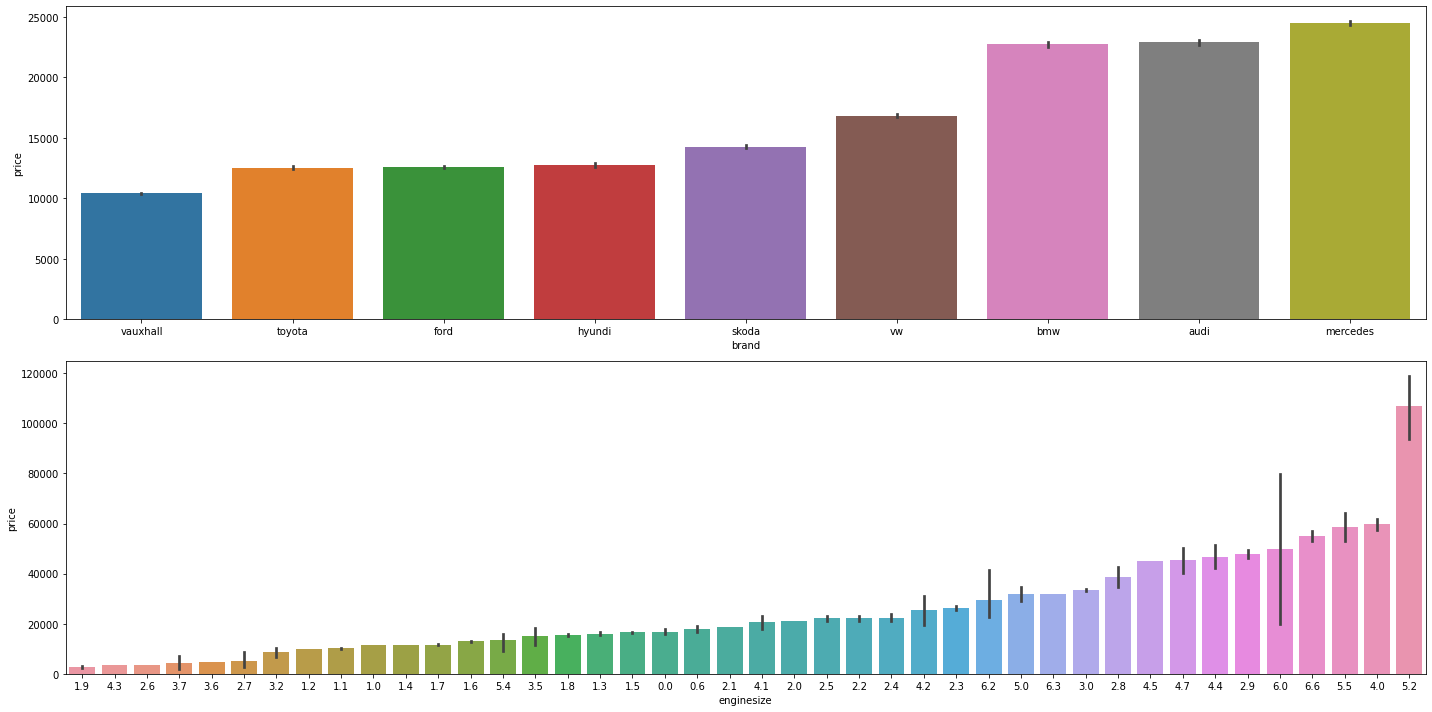

time: 6.74 s (started: 2023-03-11 00:23:38 +00:00)


In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(20,10))
axs = axs.ravel()

mean_price_brand = dataset.groupby(['brand']).mean().sort_values(by='price').index
mean_price_enginesize = dataset.groupby(['enginesize']).mean().sort_values(by='price').index

sns.barplot(data=dataset, x='brand', y='price', order=mean_price_brand, ax=axs[0])
sns.barplot(data=dataset, x='enginesize', y='price', order=mean_price_enginesize, ax=axs[1])

plt.tight_layout()
plt.show()

**Conclusão:**

*   **transmission vs price:** Carros semi-automáticos são duas vezes mais caros que os manuais. Achava que os automáticos eram os mais caros, mas estava errado. 
*   **fueltype vs price:** Aqui, há um equilíbrio maior de preços entre as categorias do que em 'transmission'. Carros a diesel e híbridos são os mais caros e seus preços médios são praticamente iguais. Os mais baratos são os movidos a combustíveis derivados de petróleo.
*   **brand vs price:** As marcas mais populares têm preços parecidos, mas há um salto de preços quando vemos marcas como 'BMW', 'Audi' e 'Mercedes'. Entre estas também há uma certa equivalência.
*   **enginesize vs price:** Quanto maior o tamanho do motor, mais caro.



###Numerical features

Vou comparar cada atributo numérico com o preço.

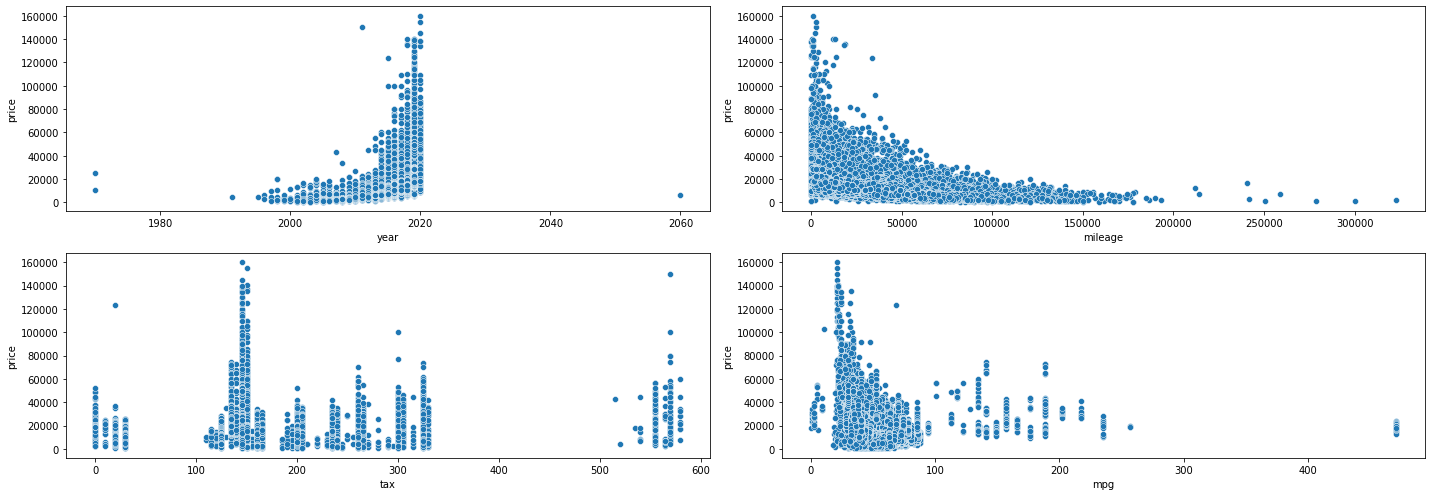

time: 3.12 s (started: 2023-03-11 00:23:52 +00:00)


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 7))
axs = axs.ravel()

sns.scatterplot(data=dataset, x='year', y='price', ax=axs[0])
sns.scatterplot(data=dataset, x='mileage', y='price', ax=axs[1])
sns.scatterplot(x=dataset['tax'].dropna(), y=dataset['price'], ax=axs[2])
sns.scatterplot(x=dataset['mpg'].dropna(), y=dataset['price'], ax=axs[3])

plt.tight_layout()
plt.show()

**Conclusão:**

*   **year vs price:** Quanto mais novos os carros, mais caros. A relação entre eles é exponencial. Os outliers são visíveis claramente.
*   **mlieage vs price:** Quanto maior a 'kilometragem', menor o preço. A relação também é exponencial. Os outliers também são visíveis.
*   **tax vs price:** Não parece haver uma relação clara entre 'tax' e 'price'.
*   **mpg vs price:** Na parte mais densa há uma forma que lembra uma relação exponencial entre os dois atributos. Os preços diminuem conforme a autonomia do carro cresce. Isso é exatamente o contrário do que eu imaginava.



Agora, vou comparar os tributos numéricos entre eles, dois a dois, para ver se há alguma relação.

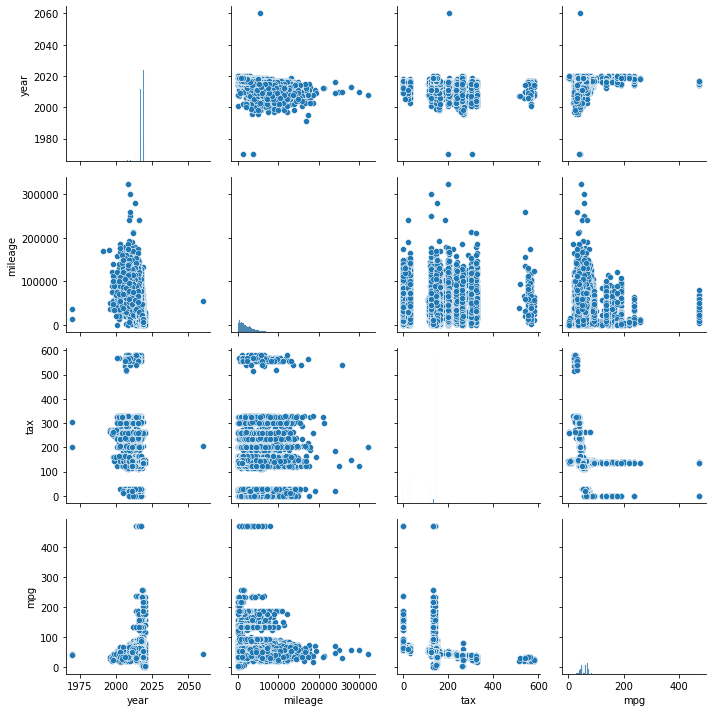

time: 10.7 s (started: 2023-03-11 00:25:37 +00:00)


In [ ]:
sns.pairplot(data=dataset, vars=['year', 'mileage', 'tax', 'mpg'])
plt.tight_layout()
plt.show()

A única informação rezoavelmente visível que encontrei é que carros mais novos possuem maior autonomia. Isso pode ser verificado no gráfico (year, mpg). Mas vou fazer uma visualização mais de perto disso.




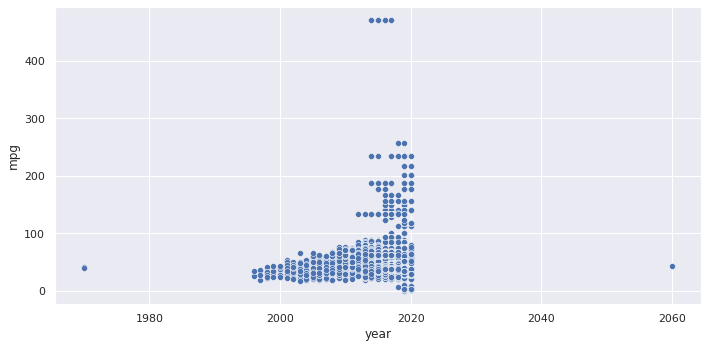

time: 400 ms (started: 2023-03-11 00:25:58 +00:00)


In [ ]:
sns.set(rc={'figure.figsize':(10, 5)})
sns.scatterplot(x=dataset['year'], y=dataset['mpg'].dropna())
plt.tight_layout()
plt.show()

**Conclusão:** Não chega a ser um crescimento exponencial explícito, mas há um padrão. De fato, quanto mais novo o carro, maior a autonomia.

Vou criar um útimo gráfico para verificar uma suspeita. Quanto menor o tamanho do motor, menos ele consome, portanto, maior a sua autonomia(mpg).

/usr/local/lib/python3.9/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


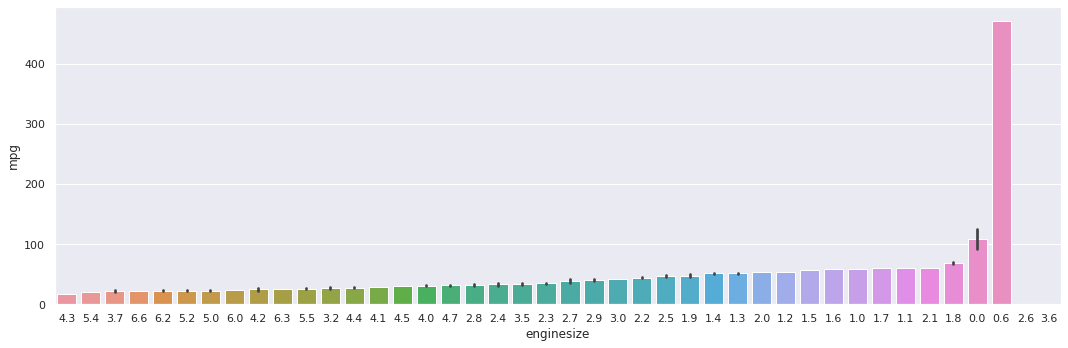

time: 2.93 s (started: 2023-03-11 00:26:20 +00:00)


In [ ]:
sns.set(rc={'figure.figsize':(15, 5)})
mean_mpg_enginesize = dataset.groupby(['enginesize']).mean().sort_values(by='mpg').index
sns.barplot(data=dataset, x='enginesize', y='mpg', order=mean_mpg_enginesize)
plt.tight_layout()
plt.show()

**Conclusão:** Minha suspetia se confirmou correta.

#Train/Test split

In [ ]:
from sklearn.model_selection import train_test_split

time: 106 ms (started: 2023-03-11 00:26:51 +00:00)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset, dataset['price'], test_size=0.2, random_state=42)

time: 54.9 ms (started: 2023-03-11 00:26:52 +00:00)


#Feature engineering

In [ ]:
%pip install category-encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 5.5 MB/s eta 0:00:00
time: 3.55 s (started: 2023-03-11 00:26:58 +00:00)


In [ ]:
from category_encoders       import TargetEncoder
from sklearn.base            import BaseEstimator, TransformerMixin
from sklearn.compose         import ColumnTransformer
from sklearn.impute          import KNNImputer
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler

time: 323 ms (started: 2023-03-11 00:27:06 +00:00)


A classe ColumnTransformer retorna por padrão um numpy array, mas para gerenciar melhor os atributos que passarão por transformações através de um pipeline, prefiro que ela retorne sempre um objeto DataFrame do Pandas. O problema é que este vem com os nomes das colunas alterados, então resolvi criar a classe abaixo para atribuir ao DataFrame que saiu do ColumnTransformer os nomes originais.

In [ ]:
class FeaturesRenamer(BaseEstimator, TransformerMixin):
    """
    Esta classe deve ser colocada diretamente dentro de um Pipeline.
    Quando 'get_feature_names_out()' é chamado ele concatena o nome do transformador ao nome de cada coluna
    que passará pela transformação. Esta classe desfaz isso retornando os nomes originais.
    """
    def __init__(self, original_names):
        if isinstance(original_names, list):
            self.original_names = original_names
        else:
            self.original_names = list(original_names)
    def fit(self, X, y=None):
        return self
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)
    def transform(self, X, y=None):
        new_names = list()
        for name in list(X.columns):
            for original in self.original_names:
                if name.endswith('__' + original):
                    new_names.append(original)
        return X.set_axis(new_names, axis=1)

time: 2.89 ms (started: 2023-03-11 00:27:09 +00:00)


Vou definir aqui quem são os atributos categóricos e numéricos.

In [ ]:
fnames_categorical = ['model', 'transmission', 'fueltype', 'enginesize', 'brand']
fnames_nominal     = ['model', 'transmission', 'fueltype', 'brand']
fnames_ordinal     = ['enginesize']
fnames_numerical   = ['year', 'mileage', 'tax', 'mpg', 'price']

time: 1.18 ms (started: 2023-03-11 00:27:10 +00:00)


##Categorical features

**Etapa ## - Nan - Busca e imputação.**

In [ ]:
X_train[fnames_categorical].isnull().sum()

model           0
transmission    0
fueltype        0
enginesize      0
brand           0
dtype: int64

time: 103 ms (started: 2023-03-11 00:27:15 +00:00)


**Etapa ## - Codificação - Atributos nominais.**

In [ ]:
ct_nominal = ColumnTransformer(transformers=[('target_encoder', TargetEncoder(), fnames_nominal)], remainder='passthrough')
ct_nominal.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('target_encoder', TargetEncoder(),
                                 ['model', 'transmission', 'fueltype',
                                  'brand'])])

time: 49.1 ms (started: 2023-03-11 00:27:17 +00:00)


**Etapa ## - Codificação - Atributos ordinais.** O único atributo ordinal do dataset, 'enginesize', já está codificado, pois já está em formato numérico. Não apenas isso, seu significado já está embutido em cada valor, bem como as proporções entre eles.

**Etapa final: Pipeline categórico completo:**

In [ ]:
pipeline_cat = Pipeline(steps=[('ct_nominal', ct_nominal),
                               ('renamer01', FeaturesRenamer(dataset.columns)),])

time: 1 ms (started: 2023-03-11 00:27:28 +00:00)


##Numerical features

**Etapa ## - Nan - Busca e imputação.** Vou usar a classe KNNImputer que calcula as 'n_neighbors' linhas mais parecidas com as que contém NaN. Ela vai fazer uma média aritmética dos valores dessas linhas no atributo que contem NaN e vai atribuir esse valor. Essa técnica é melhor do que imputar valores 'cegamente', como média, ou mediana.

In [ ]:
X_train[fnames_numerical].isnull().sum()

year          0
mileage       0
tax        7502
mpg        7502
price         0
dtype: int64

time: 17.4 ms (started: 2023-03-11 00:27:30 +00:00)


In [ ]:
ct_nan = ColumnTransformer(transformers=[('knn_imputer', KNNImputer(n_neighbors=4), fnames_numerical)], remainder='passthrough')
ct_nan.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('knn_imputer', KNNImputer(n_neighbors=4),
                                 ['year', 'mileage', 'tax', 'mpg', 'price'])])

time: 5.54 ms (started: 2023-03-11 00:27:35 +00:00)


**Etapa ##: Outliers: Identificar e tratar.** Vou substitui os outliers pelas medianas de cada atributo.

In [ ]:
class OutliersZScoreReplacer(BaseEstimator, TransformerMixin):
    """
    Substitui os outliers encontrados pelas medianas de cada atributo.
    """
    def fit(self, X, y=None):
        self.mean_std_median = list()
        for name in X.columns:
            mean   = X[name].mean()
            std    = X[name].std()
            median = X[name].median()
            self.mean_std_median.append((mean, std, median))
        return self
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)
    def transform(self, X, y=None):
        std_unit = 3
        for index, name in enumerate(X.columns):
            mean    = self.mean_std_median[index][0]
            std     = self.mean_std_median[index][1]
            median  = self.mean_std_median[index][2]
            scores  = ((X[name] - mean) / std)
            filter_mask = ((scores < -std_unit) | (scores > std_unit))
            X.loc[filter_mask, name] = median
        return X
    def get_feature_names_out(self):
        pass



ct_outliers = ColumnTransformer(transformers=[('outlires_zs_replacer', OutliersZScoreReplacer(), fnames_numerical)], remainder='passthrough')
ct_outliers.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('outlires_zs_replacer',
                                 OutliersZScoreReplacer(),
                                 ['year', 'mileage', 'tax', 'mpg', 'price'])])

time: 22.2 ms (started: 2023-03-11 00:28:13 +00:00)


**Etapa final: Pipeline numérico completo:**

In [ ]:
pipeline_num = Pipeline(steps=[('ct_nan', ct_nan),
                               ('renamer01', FeaturesRenamer(dataset.columns)),
                               ('ct_outliers', ct_outliers), 
                               ('renamer02', FeaturesRenamer(dataset.columns)),])

time: 1.1 ms (started: 2023-03-11 00:28:22 +00:00)


##Full pepiline

In [ ]:
pipeline_full = Pipeline(steps=[('pipeline_cat',    pipeline_cat),
                                ('pipeline_num',    pipeline_num),
                                ('pipeline_scaler', StandardScaler())])

X_train = pipeline_full.fit_transform(X_train, y_train)
X_test  = pipeline_full.transform(X_test)

time: 58.4 s (started: 2023-03-11 00:28:24 +00:00)


#Models

In [ ]:
%pip install git+https://github.com/scikit-optimize/scikit-optimize.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
time: 28.8 s (started: 2023-03-11 00:35:53 +00:00)


In [ ]:
from sklearn.dummy                 import DummyRegressor
from sklearn.ensemble              import RandomForestRegressor
from sklearn.metrics               import mean_squared_error
from sklearn.model_selection       import cross_val_score, RandomizedSearchCV
from skopt                         import BayesSearchCV
from tensorflow.keras.models       import Sequential
from tensorflow.keras.layers       import Dense, Dropout, InputLayer
from tensorflow.keras.callbacks    import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers   import Nadam
from xgboost                       import XGBRegressor

import numpy as np

time: 97.1 ms (started: 2023-03-11 00:36:23 +00:00)


##Scoring function: 

Na função cross_val_score(), o parâmetro 'score' espera uma função que obedeça a filosofia das funções de pontuação do Scikit Learn, "quanto maior, melhor". No entando, quando a tarefa é regressão, queremos que a distância entre o ponto calculado pelo modelo e o ponto observado seja a menor possível. Ou seja, teríamos que atribuir ao 'score' uma função que fizesse o contrário do que ele espera. A solução foi multiplicar o resultado da distância entre os dois pontos por -1. Por isso o argumento é "neg_mean_squared_error".

Já que cada chamada da função cross_val_score() vai retornar um número negativo, tudo o que preciso fazer é escolher o **maior**. Outra solução é multiplicar esse resultado por -1 e escolher o modelo que apresentar **menor** resultado. 

Por exemplo, se os modelos X e Y tiverem pontuações X=-1000 e Y=-100, o melhor modelo é o Y. Ou posso multiplicar cada escore por -1, então o resultado será X=1000 e Y=100. Neste caso, preciso lembrar que no MSE, quanto menor a distância, melhor. Portanto, Y será o melhor modelo.

##Baseline model

Vou usar uma classe já pronta do Scikit Learn como modelo de referência. Ele vai definir preços dos automóveis sempre usando a média dos preços como valor.

In [ ]:
dr = DummyRegressor(strategy='mean')
dr.fit(X_train, y_train)

y_pred = dr.predict(X_train)
print(f'RMSE: {np.sqrt(mean_squared_error(y_train, y_pred)):.2f}')

RMSE: 9729.19
time: 15.4 ms (started: 2023-03-11 00:31:30 +00:00)


Pelo que foi visto na visualização de dados modelos lineares não vão ter um bom desempenho nesta tarefa. Os gráficos não apresentam qualquer indício de uma relação linear entre as variáveis independentes e a dependente(preço). Por este motivo vou testar dois modelos baseados em árvores de decisões e uma rede neural. Vou começar com validação cruzada para ter uma ideia do desempenho de cada um sem qualquer ajuste de hiper-parâmetros. Farei ajustes nos dois mais promissores.

##RandomForestRegressor

In [ ]:
scores = cross_val_score(RandomForestRegressor(), X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)
mean = rmse_scores.mean()
std  = rmse_scores.std()
print(f'Mean RMSE: {mean:.2f}')
print(f'Std  RMSE: {std:.2f}')

Mean RMSE: 807.69
Std  RMSE: 94.44
time: 2min 16s (started: 2023-03-11 00:32:50 +00:00)


##XGBoostRegressor

In [ ]:
scores = cross_val_score(XGBRegressor(), X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)
mean = rmse_scores.mean()
std  = rmse_scores.std()
print(f'Mean RMSE: {mean:.2f}')
print(f'Std RMSE : {std:.2f}')

Mean RMSE: 753.18
Std RMSE : 81.06
time: 23.1 s (started: 2023-03-11 00:35:08 +00:00)


##Neural Network

In [ ]:
nn = Sequential()
nn.add(Dense(units=100, kernel_initializer="lecun_normal", activation='relu', input_shape=(X_train.shape[1],)))
#nn.add(Dropout(rate=0.1)) # to get some regularization
nn.add(Dense(units=100, kernel_initializer="lecun_normal", activation='relu'))
#nn.add(Dropout(rate=0.1)) # to get some regularization
nn.add(Dense(units=1, activation='relu'))

ignore cell
time: 24.4 ms (started: 2023-03-10 14:18:30 +00:00)


In [ ]:
#callbacks
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

# performance scheduling
lr_performance = ReduceLROnPlateau(factor=0.3, patience=10)

ignore cell
time: 32.3 ms (started: 2023-03-10 14:18:30 +00:00)


In [ ]:
nn.compile(loss='mse', optimizer=Nadam(learning_rate=0.001), metrics=["mse"])
history = nn.fit(X_train, y_train, 
                 validation_split=0.2, epochs=150, 
                 callbacks=[early_stopping_cb, lr_performance])

ignore cell
time: 29.3 ms (started: 2023-03-10 14:18:30 +00:00)


In [ ]:
y_pred = nn.predict(X_train)

ignore cell
time: 29.3 ms (started: 2023-03-10 14:18:30 +00:00)


##Best models hyperparameter optimization

Os modelos mais promissores, com os menores RMSE são: 

*   XGBRegressor
    * RMSE: 753.17
    * STD:  81
*   RandomForestRegressor:
    * RMSE: 810.95
    * STD:  93

Devido à extrema lentidão no ajuste dos hiperparâmetros, resolvi não ajustá-los, mas deixar o código mesmo assim. Portanto, escolho o XGBRegressor com modelo para definir o preço de um automóvel usado na Inglaterra.

In [ ]:
params = {'n_estimators': np.arange(100, 600, 100),
          'learning_rate': np.arange(0.01, 0.9, 0.1),
          'gamma': np.arange(0.01, 0.9, 0.1),
          'booster': ['gbtree', 'dart'],
          'max_depth': np.arange(6, 20, 2),
          'max_leaves': np.arange(6, 40, 2),
          'min_child_weight': np.arange(0, 20, 2),}

bscv = BayesSearchCV(XGBRegressor(), params, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42, verbose=False)
bscv.fit(X_train, y_train)

xgb_best = bscv.best_estimator_
xgb_best

/usr/local/lib/python3.9/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.51, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.11, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=16,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

time: 5h 15min 52s (started: 2023-03-11 01:04:14 +00:00)
